# **MIS581**
Capstone Project
BART
Bay Area Rapid Transit Ridership Study

In [7]:
import statistics
# standard set of includes for plotting
from datetime import datetime
import BARTPlots
import BARTQueries
import BartLibs

print("Current Time =", datetime.now())


Current Time = 2021-04-15 20:48:55.332421


Reject HO:  True  p-value : 0.9997091444669697


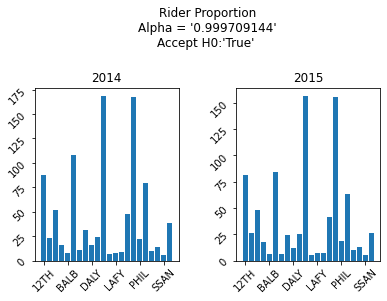

Reject HO:  False  p-value : 1.24762835690401e-176


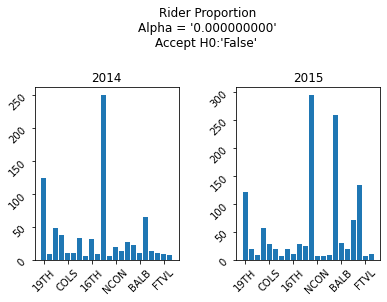

Completed


In [8]:
try:
    # BARTPlots.ShowHourlyAverageRidersSource('PITT')
    # BARTPlots.RunBARTTimeSeries()
    # BARTPlots.ShowAverageDailyRidersFromSource('PITT', 7, 2016)
    BARTPlots.GetPITTDistroCompare()

    # BARTPlots.ShowDailyRiders(7, 'PITT', 11, 3, 2015)
    # BARTPlots.ShowDailyRiders(7, 'PITT', 11, 4, 2015)
    #
    BARTPlots.CompareDailyRidersFromDestPerHour(7, 'PITT', 16, 3, 2015,
                                                7, 'PITT', 15, 4, 2015)


except(Exception) as e:
    print(e)
finally:
    print("Completed")





